DISTRIBUTION ANALYSIS REPORT

1. BASIC STATISTICS
------------------------------
Count          : 80000.0000
Mean           : -0.0612
Std            : 0.9237
Variance       : 0.8532
Median         : -0.3181
Min            : -0.8508
Max            : 34.6360
Skewness       : 7.2111
Kurtosis       : 112.1871
Range          : 35.4868

2. NORMALITY TESTS
------------------------------
DAGOSTINO      : p-value = 0.0000, Normal? No
JARQUE_BERA    : p-value = 0.0000, Normal? No
ANDERSON       : statistic = 8954.6992, Normal? No

3. DISTRIBUTION FITTING RESULTS
------------------------------
Distribution    AIC        BIC        KS p-value   Parameters
----------------------------------------------------------------------
Genextreme       81264.57  81292.44      0.0000 shape=-0.455, location=-0.416, scale=0.263
T               115446.30 115474.17      0.0000 df=1.433, location=-0.351, scale=0.231
Skewnorm        138953.49 138981.36      0.0000 skewness=33.091, location=-0.720, scale=1.135
Lapla

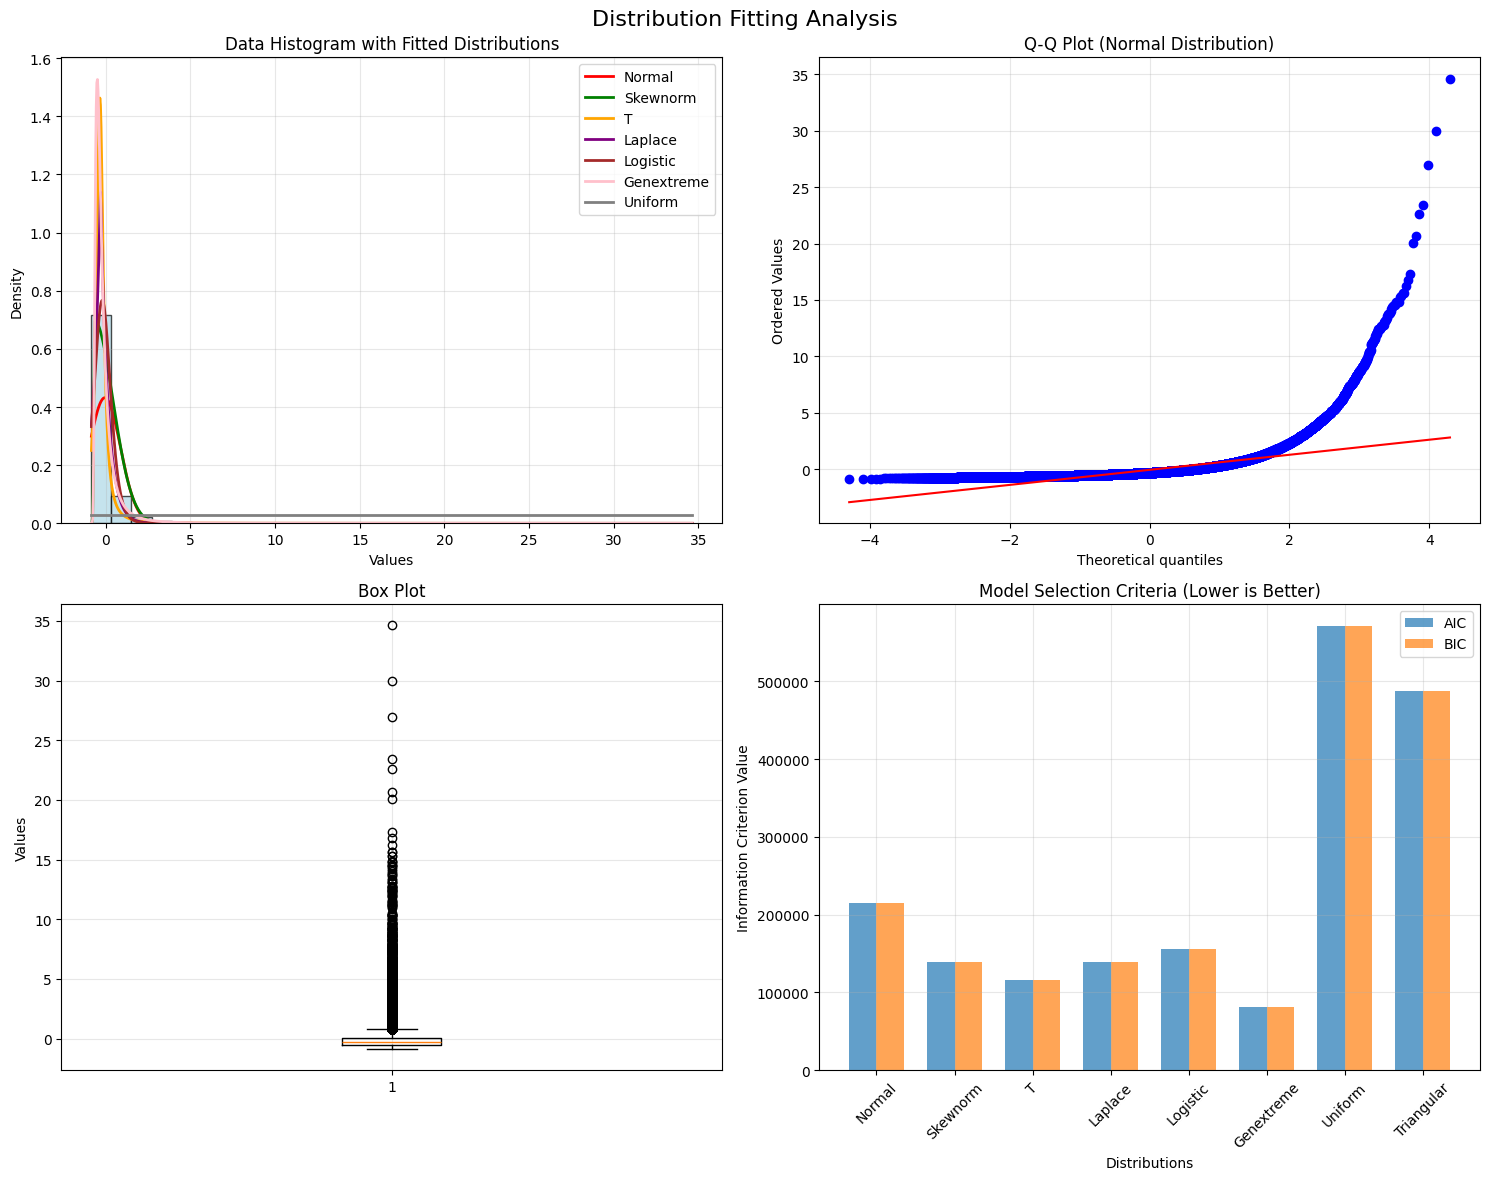


Best distribution: genextreme


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import curve_fit
import seaborn as sns
from scipy.stats import normaltest, shapiro, jarque_bera, anderson
import warnings
warnings.filterwarnings('ignore')

class DistributionFitter:
    def __init__(self, data):
        self.data = np.array(data)
        self.n = len(self.data)
        
    def basic_statistics(self):
        stats_dict = {
            'count': self.n,
            'mean': np.mean(self.data),
            'std': np.std(self.data, ddof=1),
            'variance': np.var(self.data, ddof=1),
            'median': np.median(self.data),
            'min': np.min(self.data),
            'max': np.max(self.data),
            'skewness': stats.skew(self.data),
            'kurtosis': stats.kurtosis(self.data),
            'range': np.ptp(self.data)
        }
        return stats_dict
    
    def normality_tests(self):
        results = {}
        
        # Shapiro-Wilk test (best for small samples)
        if self.n <= 5000:
            stat, p = shapiro(self.data)
            results['shapiro'] = {'statistic': stat, 'p_value': p}
        
        # D'Agostino and Pearson's test
        stat, p = normaltest(self.data)
        results['dagostino'] = {'statistic': stat, 'p_value': p}
        
        # Jarque-Bera test
        stat, p = jarque_bera(self.data)
        results['jarque_bera'] = {'statistic': stat, 'p_value': p}
        
        # Anderson-Darling test
        result = anderson(self.data, dist='norm')
        results['anderson'] = {
            'statistic': result.statistic,
            'critical_values': result.critical_values,
            'significance_levels': result.significance_level
        }



        
        return results
    
    def fit_distributions(self):
        distributions = {}
        
        # Normal Distribution
        mu, sigma = stats.norm.fit(self.data)
        distributions['normal'] = {
            'params': {'mu': mu, 'sigma': sigma},
            'aic': self.calculate_aic(stats.norm, mu, sigma),
            'bic': self.calculate_bic(stats.norm, mu, sigma),
            'ks_test': stats.kstest(self.data, lambda x: stats.norm.cdf(x, mu, sigma))
        }
        
        # Skewed Normal Distribution
        a, loc, scale = stats.skewnorm.fit(self.data)
        distributions['skewnorm'] = {
            'params': {'skewness': a, 'location': loc, 'scale': scale},
            'aic': self.calculate_aic(stats.skewnorm, a, loc, scale),
            'bic': self.calculate_bic(stats.skewnorm, a, loc, scale),
            'ks_test': stats.kstest(self.data, lambda x: stats.skewnorm.cdf(x, a, loc, scale))
        }
        
        # Student's t-distribution
        df, loc, scale = stats.t.fit(self.data)
        distributions['t'] = {
            'params': {'df': df, 'location': loc, 'scale': scale},
            'aic': self.calculate_aic(stats.t, df, loc, scale),
            'bic': self.calculate_bic(stats.t, df, loc, scale),
            'ks_test': stats.kstest(self.data, lambda x: stats.t.cdf(x, df, loc, scale))
        }
        
        # Laplace Distribution (Double Exponential)
        loc, scale = stats.laplace.fit(self.data)
        distributions['laplace'] = {
            'params': {'location': loc, 'scale': scale},
            'aic': self.calculate_aic(stats.laplace, loc, scale),
            'bic': self.calculate_bic(stats.laplace, loc, scale),
            'ks_test': stats.kstest(self.data, lambda x: stats.laplace.cdf(x, loc, scale))
        }
        
        # Logistic Distribution
        loc, scale = stats.logistic.fit(self.data)
        distributions['logistic'] = {
            'params': {'location': loc, 'scale': scale},
            'aic': self.calculate_aic(stats.logistic, loc, scale),
            'bic': self.calculate_bic(stats.logistic, loc, scale),
            'ks_test': stats.kstest(self.data, lambda x: stats.logistic.cdf(x, loc, scale))
        }
        
        # Generalized Error Distribution (GED)
        try:
            # Using genextreme as approximation for GED
            c, loc, scale = stats.genextreme.fit(self.data)
            distributions['genextreme'] = {
                'params': {'shape': c, 'location': loc, 'scale': scale},
                'aic': self.calculate_aic(stats.genextreme, c, loc, scale),
                'bic': self.calculate_bic(stats.genextreme, c, loc, scale),
                'ks_test': stats.kstest(self.data, lambda x: stats.genextreme.cdf(x, c, loc, scale))
            }
        except:
            pass
        
        # Uniform Distribution
        loc, scale = stats.uniform.fit(self.data)
        distributions['uniform'] = {
            'params': {'location': loc, 'scale': scale},
            'aic': self.calculate_aic(stats.uniform, loc, scale),
            'bic': self.calculate_bic(stats.uniform, loc, scale),
            'ks_test': stats.kstest(self.data, lambda x: stats.uniform.cdf(x, loc, scale))
        }
        
        # Triangular Distribution
        try:
            c, loc, scale = stats.triang.fit(self.data)
            distributions['triangular'] = {
                'params': {'shape': c, 'location': loc, 'scale': scale},
                'aic': self.calculate_aic(stats.triang, c, loc, scale),
                'bic': self.calculate_bic(stats.triang, c, loc, scale),
                'ks_test': stats.kstest(self.data, lambda x: stats.triang.cdf(x, c, loc, scale))
            }
        except:
            pass
        
        return distributions
    
    def calculate_aic(self, distribution, *params):
   
        log_likelihood = np.sum(distribution.logpdf(self.data, *params))
        k = len(params)
        return 2 * k - 2 * log_likelihood
    
    def calculate_bic(self, distribution, *params):
        
        log_likelihood = np.sum(distribution.logpdf(self.data, *params))
        k = len(params)
        return k * np.log(self.n) - 2 * log_likelihood
    
    def plot_distributions(self, distributions=None):
      
        if distributions is None:
            distributions = self.fit_distributions()
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Distribution Fitting Analysis', fontsize=16)
        ax1 = axes[0, 0]
        ax1.hist(self.data, bins=30, density=True, alpha=0.7, color='lightblue', edgecolor='black')
        ax1.set_title('Data Histogram with Fitted Distributions')
        ax1.set_xlabel('Values')
        ax1.set_ylabel('Density')
        
        x_range = np.linspace(self.data.min(), self.data.max(), 1000)
        colors = ['red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']
        
        for i, (dist_name, dist_info) in enumerate(distributions.items()):
            if i < len(colors):
                if dist_name == 'normal':
                    mu, sigma = dist_info['params']['mu'], dist_info['params']['sigma']
                    y = stats.norm.pdf(x_range, mu, sigma)
                elif dist_name == 'skewnorm':
                    a, loc, scale = dist_info['params']['skewness'], dist_info['params']['location'], dist_info['params']['scale']
                    y = stats.skewnorm.pdf(x_range, a, loc, scale)
                elif dist_name == 't':
                    df, loc, scale = dist_info['params']['df'], dist_info['params']['location'], dist_info['params']['scale']
                    y = stats.t.pdf(x_range, df, loc, scale)
                elif dist_name == 'laplace':
                    loc, scale = dist_info['params']['location'], dist_info['params']['scale']
                    y = stats.laplace.pdf(x_range, loc, scale)
                elif dist_name == 'logistic':
                    loc, scale = dist_info['params']['location'], dist_info['params']['scale']
                    y = stats.logistic.pdf(x_range, loc, scale)
                elif dist_name == 'genextreme':
                    c, loc, scale = dist_info['params']['shape'], dist_info['params']['location'], dist_info['params']['scale']
                    y = stats.genextreme.pdf(x_range, c, loc, scale)
                elif dist_name == 'uniform':
                    loc, scale = dist_info['params']['location'], dist_info['params']['scale']
                    y = stats.uniform.pdf(x_range, loc, scale)
                elif dist_name == 'triangular':
                    c, loc, scale = dist_info['params']['shape'], dist_info['params']['location'], dist_info['params']['scale']
                    y = stats.triang.pdf(x_range, c, loc, scale)
                
                ax1.plot(x_range, y, color=colors[i], linewidth=2, label=f'{dist_name.title()}')
        
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax2 = axes[0, 1]
        stats.probplot(self.data, dist="norm", plot=ax2)
        ax2.set_title('Q-Q Plot (Normal Distribution)')
        ax2.grid(True, alpha=0.3)
        
        
        ax3 = axes[1, 0]
        ax3.boxplot(self.data, vert=True)
        ax3.set_title('Box Plot')
        ax3.set_ylabel('Values')
        ax3.grid(True, alpha=0.3)
        ax4 = axes[1, 1]
        dist_names = list(distributions.keys())
        aic_values = [distributions[name]['aic'] for name in dist_names]
        bic_values = [distributions[name]['bic'] for name in dist_names]
        
        x_pos = np.arange(len(dist_names))
        width = 0.35
        
        ax4.bar(x_pos - width/2, aic_values, width, label='AIC', alpha=0.7)
        ax4.bar(x_pos + width/2, bic_values, width, label='BIC', alpha=0.7)
        ax4.set_xlabel('Distributions')
        ax4.set_ylabel('Information Criterion Value')
        ax4.set_title('Model Selection Criteria (Lower is Better)')
        ax4.set_xticks(x_pos)
        ax4.set_xticklabels([name.title() for name in dist_names], rotation=45)
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def generate_report(self):
        basic_stats = self.basic_statistics()
        normality_results = self.normality_tests()
        distributions = self.fit_distributions()
        
        print("="*60)
        print("DISTRIBUTION ANALYSIS REPORT")
        print("="*60)
        
        print("\n1. BASIC STATISTICS")
        print("-" * 30)
        for key, value in basic_stats.items():
            print(f"{key.capitalize():15}: {value:.4f}")
        
        print("\n2. NORMALITY TESTS")
        print("-" * 30)
        alpha = 0.05
        
        for test_name, result in normality_results.items():
            if test_name != 'anderson':
                p_value = result['p_value']
                is_normal = "Yes" if p_value > alpha else "No"
                print(f"{test_name.upper():15}: p-value = {p_value:.4f}, Normal? {is_normal}")
            else:
                stat = result['statistic']
                critical = result['critical_values'][2]  # 5% significance level
                is_normal = "Yes" if stat < critical else "No"
                print(f"{'ANDERSON':15}: statistic = {stat:.4f}, Normal? {is_normal}")
        
        print("\n3. DISTRIBUTION FITTING RESULTS")
        print("-" * 30)
        sorted_dists = sorted(distributions.items(), key=lambda x: x[1]['aic'])
        
        print(f"{'Distribution':15} {'AIC':10} {'BIC':10} {'KS p-value':12} {'Parameters'}")
        print("-" * 70)
        
        for dist_name, dist_info in sorted_dists:
            aic = dist_info['aic']
            bic = dist_info['bic']
            ks_p = dist_info['ks_test'].pvalue
            params = dist_info['params']
            
            param_str = ", ".join([f"{k}={v:.3f}" for k, v in params.items()])
            print(f"{dist_name.capitalize():15} {aic:9.2f} {bic:9.2f} {ks_p:11.4f} {param_str}")
        
        print("\n4. RECOMMENDATIONS")
        print("-" * 30)
        
        best_dist = sorted_dists[0]
        print(f"Best fitting distribution: {best_dist[0].upper()}")
        print(f"AIC: {best_dist[1]['aic']:.2f}")
        skewness = abs(basic_stats['skewness'])
        kurtosis = abs(basic_stats['kurtosis'])
        
        if skewness < 0.5 and kurtosis < 3:
            print("• Data appears approximately normal")
        elif skewness > 1:
            print("• Data is highly skewed - consider skewed normal distribution")
        elif kurtosis > 7:
            print("• Data has heavy tails - consider t-distribution or Laplace")
        if np.any(self.data < 0) and np.any(self.data > 0):
            print("• Data contains both positive and negative values")
            if best_dist[0] == 'laplace':
                print("• Laplace distribution suggests symmetric heavy tails")
            elif best_dist[0] == 'logistic':
                print("• Logistic distribution suggests symmetric with heavier tails than normal")
            elif best_dist[0] == 'skewnorm':
                print("• Skewed normal captures asymmetry in your data")
        
        return {
            'basic_stats': basic_stats,
            'normality_tests': normality_results,
            'distributions': distributions,
            'best_distribution': best_dist[0]
        }
if __name__ == "__main__":
    import pandas as pd
    sample_data = pd.read_csv('train.csv')['Y2'].values
    analyzer = DistributionFitter(sample_data)
    results = analyzer.generate_report()
    analyzer.plot_distributions()
    print(f"\nBest distribution: {results['best_distribution']}")

In [ ]:
!pip install tensorflow
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Conv1D, BatchNormalization, Activation, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
class TCN_LSTM_Model:
    def __init__(self, sequence_length=20, tcn_filters=64, lstm_units=50, dropout_rate=0.2):
        self.sequence_length = sequence_length
        self.tcn_filters = tcn_filters
        self.lstm_units = lstm_units
        self.dropout_rate = dropout_rate
        self.model = None
        self.feature_scaler = StandardScaler()
        self.target_scaler = StandardScaler()
        self.feature_columns = ['A', 'B', 'D', 'F', 'I', 'K', 'L']
        self.target_column = 'Y1'
        
    def create_tcn_block(self, inputs, filters, kernel_size, dilation_rate):
      
        # First convolution
        conv1 = Conv1D(filters=filters, 
                      kernel_size=kernel_size, 
                      dilation_rate=dilation_rate, 
                      padding='causal')(inputs)
        conv1 = BatchNormalization()(conv1)
        conv1 = Activation('relu')(conv1)
        conv1 = Dropout(self.dropout_rate)(conv1)
        
        # Second convolution
        conv2 = Conv1D(filters=filters, 
                      kernel_size=kernel_size, 
                      dilation_rate=dilation_rate, 
                      padding='causal')(conv1)
        conv2 = BatchNormalization()(conv2)
        conv2 = Activation('relu')(conv2)
        conv2 = Dropout(self.dropout_rate)(conv2)
        if inputs.shape[-1] != filters:
            residual = Conv1D(filters=filters, kernel_size=1, padding='same')(inputs)
        else:
            residual = inputs
            
        output = Add()([conv2, residual])
        output = Activation('relu')(output)
        
        return output
    
    def build_model(self, n_features):
        inputs = Input(shape=(self.sequence_length, n_features))
        
        # TCN layers with increasing dilation rates
        tcn = self.create_tcn_block(inputs, self.tcn_filters, kernel_size=3, dilation_rate=1)
        tcn = self.create_tcn_block(tcn, self.tcn_filters, kernel_size=3, dilation_rate=2)
        tcn = self.create_tcn_block(tcn, self.tcn_filters, kernel_size=3, dilation_rate=4)
        tcn = self.create_tcn_block(tcn, self.tcn_filters, kernel_size=3, dilation_rate=8)
        
        # LSTM layers
        lstm1 = LSTM(self.lstm_units, return_sequences=True, dropout=self.dropout_rate)(tcn)
        lstm2 = LSTM(self.lstm_units//2, return_sequences=False, dropout=self.dropout_rate)(lstm1)
        
        # Dense layers for final prediction
        dense1 = Dense(32, activation='relu')(lstm2)
        dense1 = Dropout(self.dropout_rate)(dense1)
        dense2 = Dense(16, activation='relu')(dense1)
        dense2 = Dropout(self.dropout_rate)(dense2)
        output = Dense(1, activation='linear')(dense2)
        
        self.model = Model(inputs=inputs, outputs=output)
    
        self.model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='mse',
            metrics=['mae', 'mse']
        )
        
        return self.model
    
    def create_sequences(self, data, target=None, is_training=True):
      
        X_sequences = []
        y_sequences = []
        
        for i in range(self.sequence_length, len(data)):
            # Get sequence of features
            X_sequences.append(data[i-self.sequence_length:i])
            
            # Get target value (only for training)
            if is_training and target is not None:
                y_sequences.append(target[i])
        
        X_sequences = np.array(X_sequences)
        
        if is_training and target is not None:
            y_sequences = np.array(y_sequences)
            return X_sequences, y_sequences
        else:
            return X_sequences
    
    def prepare_data(self, train_df, test_df=None):
     
        X_train = train_df[self.feature_columns].values
        y_train = train_df[self.target_column].values.reshape(-1, 1)
        
        # Scale the data
        X_train_scaled = self.feature_scaler.fit_transform(X_train)
        y_train_scaled = self.target_scaler.fit_transform(y_train)
        
        # Create sequences for training
        X_train_seq, y_train_seq = self.create_sequences(
            X_train_scaled, 
            y_train_scaled.flatten(), 
            is_training=True
        )
        
        result = {
            'X_train': X_train_seq,
            'y_train': y_train_seq
        }
        
       
        if test_df is not None:
            X_test = test_df[self.feature_columns].values
            X_test_scaled = self.feature_scaler.transform(X_test)
            X_test_seq = self.create_sequences(X_test_scaled, is_training=False)
            result['X_test'] = X_test_seq
            
        return result
    
    def train(self, train_df, validation_split=0.2, epochs=100, batch_size=32, verbose=1):
           # Prepare data
        data = self.prepare_data(train_df)
        X_train, y_train = data['X_train'], data['y_train']
        
        # Build model
        n_features = len(self.feature_columns)
        self.build_model(n_features)
        
        # Print model summary
        if verbose:
            print("Model Architecture:")
            self.model.summary()
        
        # Define callbacks
        callbacks = [
            EarlyStopping(
                monitor='val_loss',
                patience=15,
                restore_best_weights=True,
                verbose=1
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=8,
                min_lr=1e-7,
                verbose=1
            )
        ]
        
        # Train the model
        history = self.model.fit(
            X_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_split=validation_split,
            callbacks=callbacks,
            verbose=verbose
        )
        
        return history
    
    def predict(self, test_df):
     
        if self.model is None:
            raise ValueError("Model must be trained before making predictions")
        
    
        X_test = test_df[self.feature_columns].values
        X_test_scaled = self.feature_scaler.transform(X_test)
        X_test_seq = self.create_sequences(X_test_scaled, is_training=False)
        
        # Make predictions
        y_pred_scaled = self.model.predict(X_test_seq, verbose=0)
        
        # Inverse transform predictions
        y_pred = self.target_scaler.inverse_transform(y_pred_scaled)
        
        return y_pred.flatten()
    
    def evaluate_model(self, train_df, plot_results=True):
        """Evaluate model performance on training data"""
        # Prepare data for evaluation
        data = self.prepare_data(train_df)
        X_train, y_train = data['X_train'], data['y_train']
        
        # Make predictions on training data
        y_pred_scaled = self.model.predict(X_train, verbose=0)
        y_pred = self.target_scaler.inverse_transform(y_pred_scaled).flatten()
        y_true = self.target_scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()
        
        # Calculate metrics
        mse = mean_squared_error(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true, y_pred)
        
        print(f"Training Performance Metrics:")
        print(f"MSE: {mse:.4f}")
        print(f"MAE: {mae:.4f}")
        print(f"RMSE: {rmse:.4f}")
        print(f"R²: {r2:.4f}")
        
        if plot_results:
            plt.figure(figsize=(12, 8))
            
            # Plot actual vs predicted
            plt.subplot(2, 2, 1)
            plt.scatter(y_true, y_pred, alpha=0.5)
            plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
            plt.xlabel('Actual Y1')
            plt.ylabel('Predicted Y1')
            plt.title(f'Actual vs Predicted (R² = {r2:.3f})')
            
            # Plot time series
            plt.subplot(2, 2, 2)
            plt.plot(y_true[:200], label='Actual', alpha=0.7)
            plt.plot(y_pred[:200], label='Predicted', alpha=0.7)
            plt.xlabel('Time Steps')
            plt.ylabel('Y1 Values')
            plt.title('Time Series Comparison (First 200 points)')
            plt.legend()
            
            # Plot residuals
            plt.subplot(2, 2, 3)
            residuals = y_true - y_pred
            plt.scatter(y_pred, residuals, alpha=0.5)
            plt.axhline(y=0, color='r', linestyle='--')
            plt.xlabel('Predicted Y1')
            plt.ylabel('Residuals')
            plt.title('Residual Plot')
            
            # Plot residual distribution
            plt.subplot(2, 2, 4)
            plt.hist(residuals, bins=50, alpha=0.7, edgecolor='black')
            plt.xlabel('Residuals')
            plt.ylabel('Frequency')
            plt.title('Residual Distribution')
            
            plt.tight_layout()
            plt.show()
        
        return {
            'mse': mse,
            'mae': mae, 
            'rmse': rmse,
            'r2': r2,
            'predictions': y_pred,
            'actual': y_true
        }
    
    def plot_training_history(self, history):
        """Plot training history"""
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(history.history['mae'], label='Training MAE')
        plt.plot(history.history['val_mae'], label='Validation MAE')
        plt.title('Model MAE')
        plt.xlabel('Epoch')
        plt.ylabel('MAE')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

# Example usage:
# Initialize the model
tcn_lstm = TCN_LSTM_Model(
    sequence_length=20,    # Look back 20 time steps
    tcn_filters=64,        # TCN filter size
    lstm_units=50,         # LSTM units
    dropout_rate=0.2       # Dropout for regularization
)

# Train the model
history = tcn_lstm.train(
    train_df=train,        # Your training dataframe
    validation_split=0.2,  # 20% for validation
    epochs=100,            # Maximum epochs
    batch_size=32,         # Batch size
    verbose=1              # Show training progress
)

# Plot training history
tcn_lstm.plot_training_history(history)

# Evaluate model performance
evaluation_results = tcn_lstm.evaluate_model(train, plot_results=True)

# Make predictions on test data
test_predictions = tcn_lstm.predict(test)

# Add predictions to test dataframe
test['Y1_predicted'] = np.nan
test.iloc[tcn_lstm.sequence_length:, test.columns.get_loc('Y1_predicted')] = test_predictions

print(f"Test predictions shape: {test_predictions.shape}")
print(f"Sample predictions: {test_predictions[:10]}")
